###  <center> Analyze $U$ result</center>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import glob
import numpy as np
import re

In [3]:
def norm(vec):
    return vec.dot(vec) ** (1/2)

def xi_a(C):
    L = len(C)
    return L/(2*np.pi) * (calculate_FourierTransform(C)/calculate_FourierTransform(C,(2*np.pi/L,0)) -1 ) **(1/2)

def xi_a_div_L(C):
    return xi_a(C) / len(C)
def xi_b(C):
    L = len(C)
    q1 = np.array((2*np.pi/L,0))
    q2 = 2*q1
    return 1/norm(q1) * ((calculate_FourierTransform(C,q1)/calculate_FourierTransform(C,q2)-1)/ \
                            (4- calculate_FourierTransform(C,q1) / calculate_FourierTransform(C,q2)))**(1/2)
def xi_b_div_L(C):
    return xi_b(C) / len(C)

def calculate_FourierTransform(C,k=(0,0)):
    k = np.array(k)
    return sum(C[i,j]*np.cos(k.dot(np.array((i,j)) )) for i in range(len(C)) for j in range(len(C[i]))) / len(C)**2  

def extendCij(CSVname):
    '''input Cij df would contain only upper triangle, we need to add the half data and convert to numpy array'''
    CijDataframe = pd.read_csv(CSVname)
    condition = CijDataframe.columns[0]
    CijDataframe = CijDataframe.drop([condition],axis=1)
    Cij = CijDataframe.to_numpy()
    return Cij + Cij.transpose() - np.diag(np.diag(Cij))

def conditions(CSVnames):
    ''' for our name of df would be aaa_bb_ccc.csv , we can check the parameter by check aaa/bb/ccc'''
    A = CSVnames[0];B = CSVnames[1]
    A_parameters = A.split('_')
    B_parameters = B.split('_')
    for i,p in enumerate(A_parameters):
        if p != B_parameters[i]:
            label = re.findall(r'([a-zA-Z]*)\d\.?\d*',p)[0]
            ithVariable = i
            val_index = p.index(label)+ len(label)
            break
    variables = []
    for name in CSVnames:
        variables.append(float(name.split('_')[ithVariable][val_index:]))
        
    condition = pd.read_csv(CSVnames[0]).columns[0]  # WLOG, take 0th as condition
    return condition, label,variables


Text(0,0.5,'energy difference')

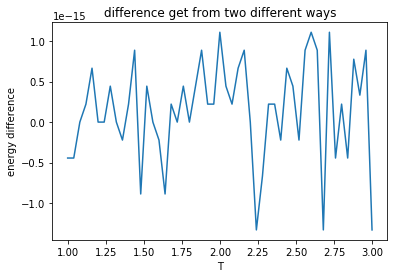

In [4]:
def getNNCorrelation(Cij):
    return Cij[0][1]
def getEnergy(Cij):
    return getNNCorrelation(Cij) * (-2)

m=8;
RG = int(np.log2(m))-1
exact_data = pd.read_csv('exact_data_without_approx (m = {}).csv'.format(m))
Cij_csvs   = glob.glob(r"Ising_square_RG{}/*.csv".format(RG))
condition,label,parameters = conditions(Cij_csvs)
Cijs = map(extendCij,Cij_csvs)
Energy = [getEnergy(Cij) for Cij in Cijs]
exact_data['energy_from_TN'] = Energy
exact_data['energy_difference'] = exact_data['E_exact_over_mn'] - exact_data['energy_from_TN']
exact_data.to_csv('exact_data_2 (m = {}).csv'.format(m))
plt.plot(exact_data['T'],exact_data['energy_difference'])
plt.title('difference get from two different ways')
plt.xlabel('T')
plt.ylabel('energy difference')

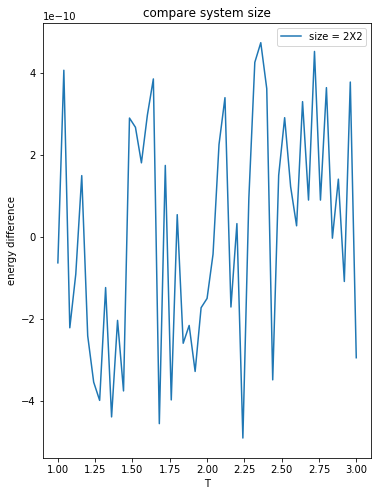

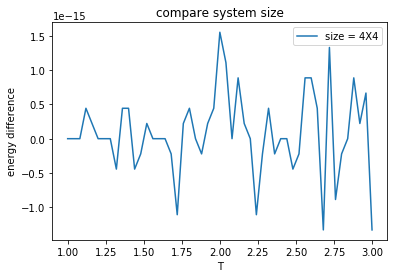

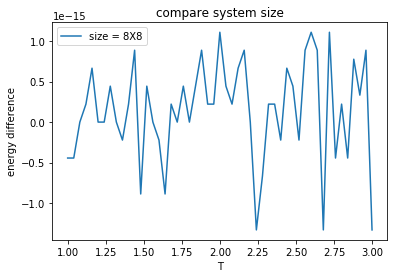

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
for m in [2,4,8]:
    exact_data = pd.read_csv('exact_data_2 (m = {}).csv'.format(m))
    Ts = exact_data['T']
    difference = exact_data['energy_difference']
    plt.plot(Ts,difference,label='size = {0}X{0}'.format(m))
    plt.xlabel('T')
    plt.ylabel('energy difference')
    plt.legend(loc=0)
    plt.title('compare system size')
    plt.show()


C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


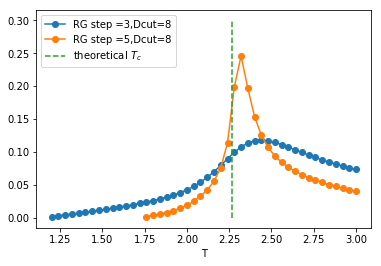

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.00199114, 0.00387133,
       0.00584758, 0.00820944, 0.01113516, 0.01479826, 0.01937755,
       0.02517353, 0.03318322, 0.04232388, 0.05564123, 0.07609943,
       0.11396647, 0.1985419 , 0.24575638, 0.1969505 , 0.15349394,
       0.12560943, 0.10698996, 0.09394594, 0.08433892, 0.07689507,
       0.0708433 , 0.06574028, 0.06131807, 0.05740535, 0.05388679,
       0.05068324, 0.04774049, 0.04502106, 0.0424981 , 0.04015138])

In [16]:
# fix Dcut , to see zeta_a & zeta_b varied with RG step
def plotCijRelated(RGsteps,function,select='Cij*D8*csv',show_traisition=False,yscale=None):
    max_vals = []
    min_vals = []
    for i,RGstep in enumerate(RGsteps):
        RGnum = "RG" +str(RGstep)
        Cij_csvs = sorted(glob.glob(r"./Cij/{}/{}".format(RGnum,select)))
        condition,label,parameters = conditions(Cij_csvs)
        Cijs = map(extendCij,Cij_csvs)
        calculateResult = [function(C) for C in Cijs]
        max_vals.append(max(calculateResult))
        min_vals.append(min(calculateResult))
        plt.plot(parameters,calculateResult,"o-",label="RG step ={},{}".format(RGstep,condition))
    if show_traisition:
        max_val = max(max_vals)
        if np.isnan(max_val):
            max_val = 0.3
        min_val = min(min_vals)
        if np.isnan(min_val):
            min_val = 0
        plt.plot([2/(np.log(1+2**(1/2))) for _ in range(150)],np.linspace(min_val,max_val,150),'--',\
                 label="theoretical $T_c$")
    plt.xlabel(label)
    if yscale:    
        plt.yscale(yscale)
    plt.legend(loc=0)
    plt.show()
    return np.array(calculateResult)
# plotCijRelated([3,5],xi_a_div_L,show_traisition=True)
plotCijRelated([3,5],xi_b_div_L,show_traisition=True)

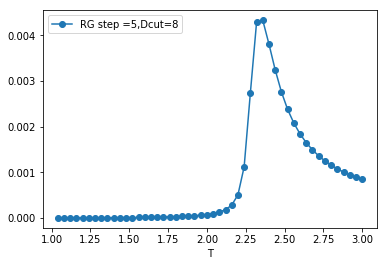

[False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


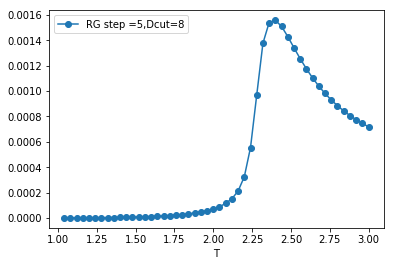

[-1.26336283e-03 -1.39516543e-03 -1.51654254e-03 -1.62345982e-03
 -1.71212306e-03 -1.77918979e-03 -1.82197404e-03 -1.83867099e-03
 -1.82853517e-03 -1.79197769e-03 -1.73046902e-03 -1.64609448e-03
 -1.54032211e-03 -1.43687589e-03 -1.22184147e-03 -1.01600846e-03
 -7.22588667e-04 -2.84276251e-04  4.69477262e-04  1.77396416e-03
  4.04433777e-03  7.96074383e-03  1.46134545e-02  2.57136486e-02
  4.38215693e-02  7.32213611e-02  1.24979218e-01  1.98142140e-01
  3.26734731e-01  5.58244751e-01  1.01686948e+00  1.82638072e+00
  2.11356588e+00  1.81486072e+00  1.44569807e+00  1.15143419e+00
  9.33747069e-01  7.75190681e-01  6.57736054e-01  5.67758301e-01
  4.96104839e-01  4.37249321e-01  3.87749700e-01  3.45358651e-01
  3.08540541e-01  2.76223125e-01  2.47649417e-01  2.22270189e-01
  1.99667964e-01  1.79508652e-01]
[3.00126336 3.00139517 3.00151654 3.00162346 3.00171212 3.00177919
 3.00182197 3.00183867 3.00182854 3.00179198 3.00173047 3.00164609
 3.00154032 3.00143688 3.00122184 3.00101601 3.00072

In [24]:
from functools import partial
RG_steps = [5]
L = 2**6
q1 = np.array((2*np.pi/L,0))
q2 = 2*q1
S_q1 = partial(calculate_FourierTransform,k=q1)
S_q2 = partial(calculate_FourierTransform,k=q2)
S_q1_res = plotCijRelated(RG_steps,S_q1)
print(S_q1_res > S_q2_res)
S_q2_res = plotCijRelated(RG_steps,S_q2)
numerator =S_q1_res / S_q2_res -1
print(numerator)
denominator = 4-S_q1_res/S_q2_res
print(denominator)

it seems at low temperature, $S(q_1)$ and $S(q_2)$ may be very small. <br>
And when calculate numerator, $\frac{S(q_1)}{S(q_2)} -1 $ may  small than 0. 
Taking the square root, which end up some imagary number <br>
Also, we find the fourier transform result is very different when we enlarge system size @@? <br>
Maybe if would be OK if we enlarge bond dimension!

## sanity check : $M_2$ and $\sum_{i,j}\sigma_i\sigma_j$

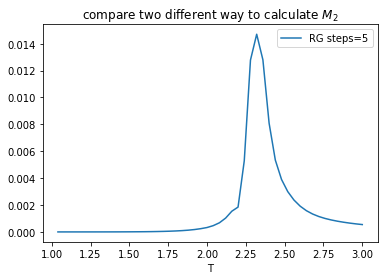

In [3]:
RGstep = 5
RGnum = "RG" +str(RGstep)
Cij_csvs = sorted(glob.glob(r"./Cij/{}/Cij*D8.csv".format(RGnum)))
condition,label,parameters = conditions(Cij_csvs)

Cijs = map(extendCij,Cij_csvs)
M2_formFourier = [calculate_FourierTransform(C) for C in Cijs]
# plt.plot(parameters,M2_formFourier,"bo-",label="$\sum_{}\sigma_i\sigma_j$:RG step ={},{}".format('i,j',RGstep,condition))
M2_csv = pd.read_csv(r'./M2M4/M2_D8.csv')
# plt.plot(parameters,M2_csv['RG steps=5'],"r--",label='$M_2$ (RG step ={},{})'.format(RGstep,condition))
plt.plot(parameters,M2_formFourier-M2_csv['RG steps=5'])
plt.xlabel(label)
plt.title('compare two different way to calculate $M_2$')
plt.legend(loc=0)

Near transition point the difference is much larger, so our next problem is: <br>
which is better ? <br>
- find theoretical $M^2$
- try to make the difference 
- compare to different L & bond dimension $\chi$

TGT
3


In [92]:
Cij_csvs = sorted(glob.glob(r"./Cij/RG5/Cij*D8.csv"))
Cijs = map(extendCij,Cij_csvs)
L = 64
test = [calculate_FourierTransform(C,(2*np.pi/L,0)) for C in Cijs]
print(test)

[4.991616992520748e-07, 6.762996767896413e-07, 8.993699636973248e-07, 1.1764478839613676e-06, 1.516551145260334e-06, 1.929781557020912e-06, 2.4275120474263738e-06, 3.0226318089202173e-06, 3.729867233898251e-06, 4.56620309852e-06, 5.551438701257601e-06, 6.7089289789583925e-06, 8.066587651527307e-06, 9.657475648246314e-06, 1.152358371619603e-05, 1.3717276987532416e-05, 1.6305042971928195e-05, 1.9371342265091202e-05, 2.3032982492307704e-05, 2.7445876252616086e-05, 3.282994221058915e-05, 3.950327929444776e-05, 4.794143168166908e-05, 5.888142885397777e-05, 7.351259360927303e-05, 9.406405822102827e-05, 0.00013032116450860016, 0.00018088840921547634, 0.0002816995906295898, 0.0005056371573605115, 0.001119245999931439, 0.002736676845833839, 0.0042862578070794865, 0.004334065318763999, 0.00380969683803169, 0.0032464333995131807, 0.002763386540779333, 0.0023797194280836993, 0.002079986603384815, 0.0018419368004635916, 0.0016497916147739087, 0.0014921640591846227, 0.0013610782091353917, 0.00125079

In [88]:
test = np.array((1,0))

0.09817477042468103

In [71]:
M2_csv = pd.read_csv(r'./M2M4/M2_D8.csv')
M2_csv.columns

Index(['Dcut=8', 'RG steps=0', 'RG steps=1', 'RG steps=2', 'RG steps=3',
       'RG steps=4', 'RG steps=5'],
      dtype='object')